In [419]:
import matplotlib.pyplot as plt

%matplotlib inline

In [420]:
dataset = 'classc'

In [421]:
# Read our results

import json

def combine_dict(dict1, dict2):
    for key in dict2.keys():
        if key in dict1:
            dict1[key] = combine_dict(dict1[key], dict2[key])
        else:
            dict1[key] = dict2[key]
    return dict1

def combine_dicts(dicts):
    u = None
    for d in dicts:
        if u is None:
            u = d
        else:
            u = combine_dict(u, d)
    return u

In [422]:
import site

site.addsitedir("/home/xyhang/projects/VCIP2023-grand-challenge/")

from tools.bdrate import BD_RATE, BD_PSNR

In [423]:
from dataclasses import dataclass
from typing_extensions import TypeAlias, List, Dict
import numpy as np

@dataclass
class ResultUnit:
    r: float
    d: float
    t: float

ImageResults: TypeAlias = List[ResultUnit]

class DatasetResults:
    def __init__(self):
        self.img_results: Dict[str, ImageResults] = {}

    def update_image_result(self, img_name, r, d, t):
        self.img_results.setdefault(img_name, []).append(ResultUnit(r=r, d=d, t=t))

    def sort(self):
        for k in self.img_results.keys():
            self.img_results[k].sort(key=lambda x: x.r)

    @property
    def avg_r(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.r for x in rs]))
        return results

    @property
    def avg_d(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.d for x in rs]))
        return results

    @property
    def avg_t(self) -> float:
        self.sort()
        results = []
        for rs in zip(*list(self.img_results.values())):
            results.append(np.mean([x.t for x in rs]))
        return results

    def _bd_rate_imgwise(self, anchor):
        self.sort()
        anchor.sort()
        ans = {}
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)
            bd_rate = BD_RATE(R1, D1, R2, D2)
            ans[filename] = bd_rate
        return ans

    def bd_rate(self, anchor):
        ans = self._bd_rate_imgwise(anchor)
        return np.mean(list(ans.values()))

    def bd_psnr(self, anchor):
        self.sort()
        anchor.sort()
        ans = []
        for filename, data in self.img_results.items():
            if filename not in anchor.img_results:
                raise ValueError(f"filename {filename} not in anchor")
            data_anchor = anchor.img_results[filename]
            R1 = [x.r for x in data_anchor]
            D1 = [x.d for x in data_anchor]
            R2 = [x.r for x in data]
            D2 = [x.d for x in data]
            R1 = np.unique(R1)
            R2 = np.unique(R2)
            D1 = np.unique(D1)
            D2 = np.unique(D2)
            bd_rate = BD_PSNR(R1, D1, R2, D2)
            ans.append(bd_rate)
        return np.mean(ans)
    
    def time_saving(self, anchor):
        self.sort()
        anchor.sort()
        ans = []

        

In [424]:
def read_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [425]:
import glob

results = glob.glob(f"{dataset}/*.json")

data_ours = combine_dicts([read_json(r) for r in results])

In [426]:
# speedups = [0.01, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
speedups = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]
qscales = [0.3, 0.4, 0.5, 0.6, 0.7]

In [427]:
data_ours['qscale=0.3'].keys()

dict_keys(['speedup=0.01', 'speedup=0.25', 'speedup=0.5', 'speedup=0.75', 'speedup=1.0', 'speedup=1.25', 'speedup=1.5', 'speedup=2.0', 'speedup=3.0'])

In [428]:
ours_results = {k: DatasetResults() for k in speedups}

for speedup in speedups:
    for qscale in qscales:
        glob_results = data_ours[f"qscale={qscale}"][f"speedup={speedup}"]
        for filename, result in glob_results.items():
            if filename[:3] != "avg":
                ours_results[speedup].update_image_result(
                    filename, result["bpp"], result["PSNR"], result["t_dec"]
                )

In [429]:
import pandas as pd

def read_xls(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df

In [430]:
anchors = ['bpg', 'evc', 'jpeg', 'mlic', 'qarv', 'tcm', 'webp', 'vtm']

anchor_results: Dict[str, DatasetResults] = {k: DatasetResults() for k in anchors}

anchors_r = {}
anchors_d = {}
anchors_t = {}

for anchor in anchors:
    if anchor == 'vtm':
        xls_data: pd.DataFrame = read_xls(f"VTM.xls", dataset)
        filename = None
        for index, x in xls_data.iterrows():
            if isinstance(x.Filename, (str, int)) or (isinstance(x.Filename, float) and not np.isnan(x.Filename)):
                if isinstance(x.Filename, float):
                    filename = str(int(x.Filename))
                else:
                    filename = str(x.Filename)
            anchor_results[anchor].update_image_result(
                filename, x.bpp, x["RGB psnr"], x["Dec Time"] * 12.387
            )
    else:
        anchor_data = read_json(f"../../anchors/{dataset}/{anchor}/results.json")
        if anchor == 'bpg' and dataset == 'classa':
            for t1 in anchor_data.values():
                for t2 in t1.values():
                    for filename, result in t2.items():
                        if filename[:3] != "avg":
                            anchor_results[anchor].update_image_result(
                                filename, result["bpp"], result["PSNR"], result["t_dec"]
                            )
        else:
            for t2 in anchor_data.values():
                for filename, result in t2.items():
                    if filename[:3] != "avg":
                        anchor_results[anchor].update_image_result(
                            filename, result["bpp"], result["PSNR"], result["t_dec"]
                        )

In [431]:
import scipy


def interpolator(R, PSNR, min_r=None, max_r=None):
    lR = np.log(R)

    # integration interval
    min_int = min(PSNR)
    max_int = max(PSNR)

    lin = np.linspace(min_int, max_int, num=100, retstep=True)
    interval = lin[1]
    samples = lin[0]
    v = scipy.interpolate.pchip_interpolate(
        np.sort(PSNR), lR[np.argsort(PSNR)], samples
    )

    results = []
    for r, d in zip(np.exp(v), samples):
        if min_r < r and r < max_r:
            results.append((r,d))
    return [x[0] for x in results], [x[1] for x in results]

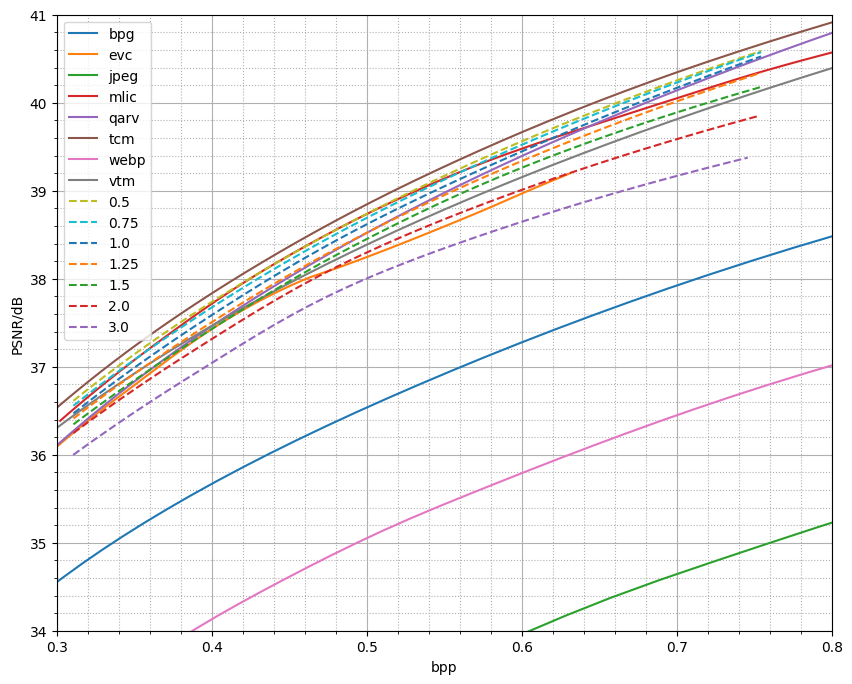

In [448]:
plt.figure(figsize=(10, 8))

min_r = 

for k, v in anchor_results.items():
    r = v.avg_r
    d = v.avg_d
    r, d = interpolator(r, d)
    plt.plot(r, d, label=k)

for speedup in speedups:
    r = ours_results[speedup].avg_r
    d = ours_results[speedup].avg_d
    r, d = interpolator(r, d)

    plt.plot(
        r,
        d,
        linestyle="--",
        label=speedup,
    )
plt.legend()
# plt.xlim(0, 1)
# plt.ylim(28, 42)

plt.xlabel("bpp")
plt.ylabel("PSNR/dB")
plt.xlim(0.3, 0.8)
plt.ylim(34, 41)
plt.minorticks_on()
plt.grid(which="major", linestyle="-")
plt.grid(which="minor", linestyle=":")

plt.show()

bpg 0.8355426867802939 0.0
evc 0.3204653108561481 -31.59669637033943
jpeg 0.03128424286842346 217.3194518639631
mlic 3.7707595538209984 -39.29405914288255
qarv 1.2504595012375803 -36.560311888065804
tcm 2.3824248457396475 -36.0945703468385
webp 0.053745906461368904 68.82215791690344
vtm 2.0874964886224 -36.31503262812215
0.5 1.5545461515585584 -42.005715064046775
0.75 1.3033069193363191 -41.29569454181074
1.0 0.9734645565350849 -40.19525095128521
1.25 0.7607974727948507 -38.815630202297356
1.5 0.6313007553418477 -37.69699773759387
2.0 0.4681305189927419 -35.16037883517813
3.0 0.29073848923047385 -29.864305053364635


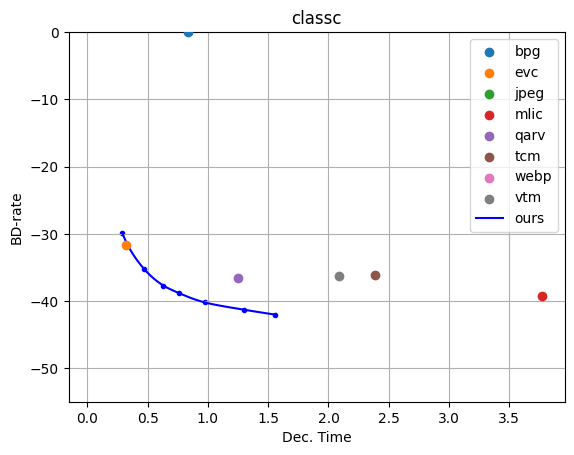

In [450]:
anchor = anchor_results['bpg']

for k, v in anchor_results.items():
    bd = v.bd_rate(anchor)
    t = np.mean(v.avg_t)
    # r, d = interpolator(r, d)
    plt.scatter(t, bd, label=k, zorder=10)
    if k == 'evc':
        evc_t, evc_bd = t, bd
    print(k, t, bd)

ours_bd = []
ours_t = []

for k, v in ours_results.items():
    bd = v.bd_rate(anchor)
    t = np.mean(v.avg_t)
    if not (bd > evc_bd and t > evc_t):
        ours_bd.append(bd)
        ours_t.append(t)
        print(k, t, bd)

t, bd = interpolator(ours_t, ours_bd)

plt.plot(t, bd, label='ours', color='blue')
plt.scatter(ours_t, ours_bd, marker='.', color='blue')
plt.xlabel("Dec. Time")
plt.ylabel("BD-rate")
plt.ylim(top=0.0)
plt.grid(zorder=0)
plt.title(dataset)
plt.legend()

In [435]:
import matplotlib as mpl

def plot_img_results(results: DatasetResults, anchor: DatasetResults):
    ans_results = results._bd_rate_imgwise(anchor)
    ans_results = [(k, v) for k, v in ans_results.items()]
    ans_results.sort(key=lambda x:x[1])
    plt.figure(figsize=(10, 3))

    cm = mpl.colormaps['coolwarm']
    labels, values = zip(*ans_results)
    colors = np.asarray(values)
    colors = colors / (np.abs(colors).max())
    colors = colors / 2 + 0.5
    colors = [cm(k) for k in colors]
    plt.bar(labels, values, color=colors, zorder=10)
    plt.ylabel("BD-rate (%)")
    plt.grid(axis='y', zorder=0)
    plt.xticks(rotation=90)

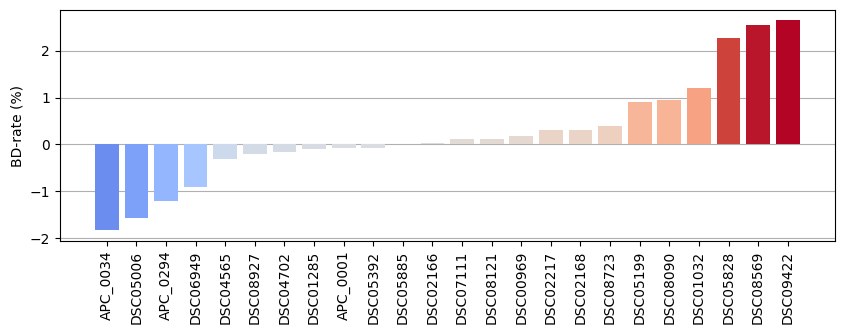

In [455]:
plot_img_results(ours_results[0.5], anchor_results["tcm"])

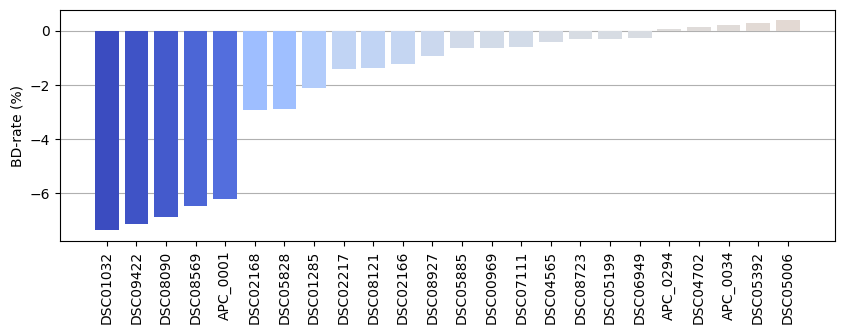

In [436]:
plot_img_results(ours_results[1.0], anchor_results["qarv"])
plt.savefig("ours_qarv_imgwise.png", dpi=300, bbox_inches='tight')
plt.savefig("ours_qarv_imgwise.pdf", bbox_inches="tight")

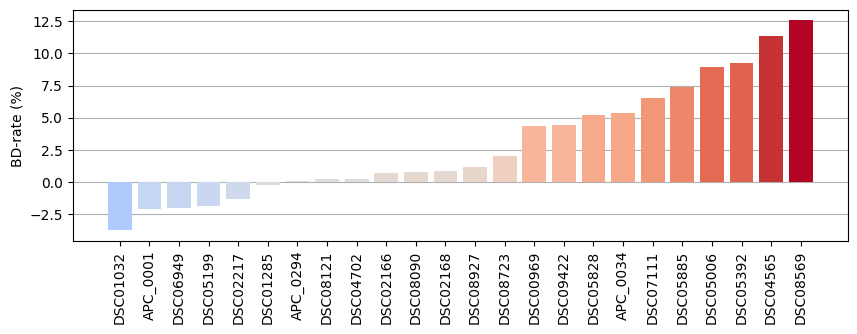

In [437]:
plot_img_results(ours_results[3.0], anchor_results["evc"])

In [438]:
ours_results[3.0].img_results['19']

KeyError: '19'

In [ ]:
anchor_results["evc"].img_results["19"]

[ResultUnit(r=0.2773844401041667, d=32.208251261495874, t=0.06126046180725098),
 ResultUnit(r=0.3705647786458333, d=33.32124402501516, t=0.062468767166137695),
 ResultUnit(r=0.4899495442708333, d=34.55167939641409, t=0.061202049255371094),
 ResultUnit(r=0.6868896484375, d=36.211913132452295, t=0.06175684928894043),
 ResultUnit(r=0.7147216796875, d=36.40414884068899, t=0.0652456283569336),
 ResultUnit(r=0.7610270182291666, d=36.6953890559905, t=0.08214807510375977),
 ResultUnit(r=0.8222249348958334, d=37.05466439702444, t=0.07242393493652344),
 ResultUnit(r=0.8950602213541666, d=37.45580365636282, t=0.06200909614562988),
 ResultUnit(r=0.9353434244791666, d=37.656496071600245, t=0.07178354263305664)]

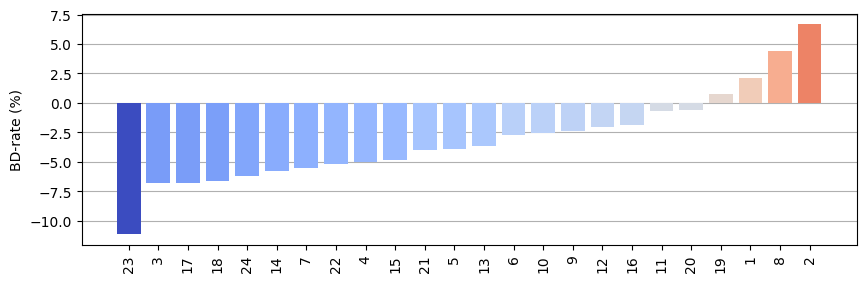

In [ ]:
plot_img_results(ours_results[1.0], anchor_results["vtm"])
plt.savefig("ours_vtm_imgwise.png", dpi=300, bbox_inches="tight")
plt.savefig("ours_vtm_imgwise.pdf", bbox_inches="tight")

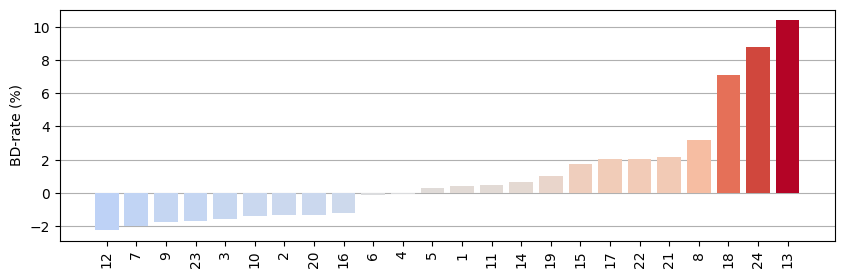

In [ ]:
plot_img_results(anchor_results["mlic"], anchor_results["tcm"])

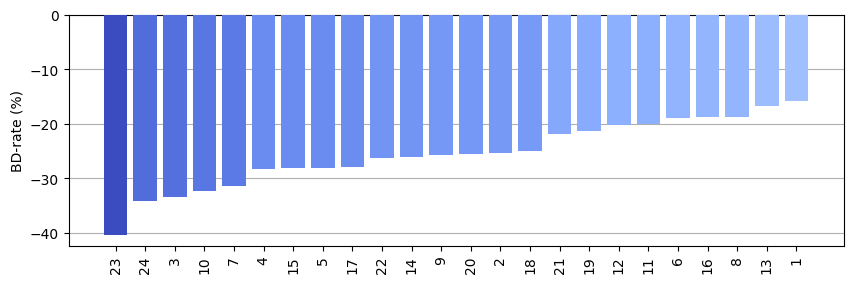

In [ ]:
plot_img_results(anchor_results["tcm"], anchor_results["bpg"])

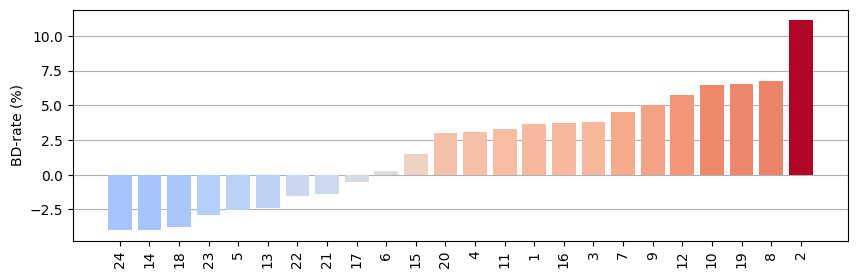

In [ ]:
plot_img_results(anchor_results["qarv"], anchor_results["vtm"])

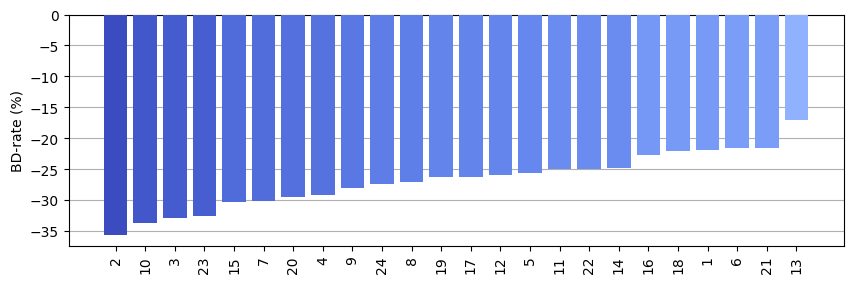

In [ ]:
plot_img_results(anchor_results["vtm"], anchor_results["bpg"])

In [ ]:
import glob
outputs = glob.glob(
    "/home/xyhang/projects/VCIP2023-grand-challenge/experiments/SAv1/performance/classd/PSNR/speedup-3.0/*/*.bin"
)
print(len(outputs))

120


In [ ]:
from src.fileio import FileIO

In [ ]:
for filename in outputs:
    fio = FileIO.load(filename, False, 256)
    print(fio.method_id)

[1 1 1 1 1 0]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 0 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 0]
[1 1 1 1 1 0]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 0 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 0 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 0]
[1 1 1 1 1 0]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 0 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 1 1 1 1 1]
[1 0 1 1 1 1]
[1 1 1